# Introdução
Análise de sentimentos sempre foi um assunto que tive interesse, além de poder utilizá-la para criar soluções que podem ser usadas na empresa onde trabalho. O objetivo desse projeto é desenvolver uma solução que consiga identificar se uma frase possui um sentimento negativo ou positivo.

Esse conjunto de dados foi fornecido generosamente pela Olist, a maior loja de departamentos dos mercados brasileiros. O Olist conecta pequenas empresas de todo o Brasil a canais sem problemas e com um único contrato. Esses comerciantes podem vender seus produtos através da Olist Store e enviá-los diretamente aos clientes usando os parceiros de logística da Olist. Veja mais no site: www.olist.com

Depois que um cliente compra o produto na Olist Store, um vendedor é notificado para atender a esse pedido. Depois que o cliente recebe o produto ou a data estimada de entrega é vencida, ele recebe uma pesquisa de satisfação por e-mail, onde pode anotar a experiência de compra e anotar alguns comentários.

Um pedido pode ter vários itens.
Cada item pode ser atendido por um vendedor distinto.
Todo o texto que identifica lojas e parceiros foi substituído pelos nomes das grandes casas de Game of Thrones.

In [70]:
import pandas as pd
import numpy as np
import spacy
import nltk
import string
from nltk.stem import RSLPStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from time import time

In [71]:
#Carrega os dados
df_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
df_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [72]:
#Qual a quantidade de registros nao informados por coluna?
df_reviews.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [73]:
# Removendo registros com comentarios nulos
reviews = df_reviews.dropna(subset=['review_comment_message'])

In [74]:
# Amostra
for i in range(5):
    print(f'Review {i+1}: {np.random.choice(reviews["review_comment_message"])}')

Review 1: Produto chegou no prazo ótimo long 
Review 2: Mandei várias dúvidas por email, não recebi respostas.
Review 3: Produto de ótima qualidade. Não estava disponível na cor do anúncio, mas o vendedor entrou em contato prontamente. Parabéns pelo excelente atendimento!
Review 4: Produto chegou bem antes do prazo. Muito bem embalado. Tudo certinho. Recomendo
Review 5: Comprar na baratheon é garantia de receber um bom produto.


# Normalização
    - convertento para minúsculo
    - removendo as palavras com menos de 3 e maios de 25 caracteres
    - removendo as stopwords
    - removendo as pontuações
    - removendo a acentuação
    - removendo as palavras de baixa frequência, menor 6
    - rotulando em 'ADJ', 'VERB', 'ADV'
    - stemizando
    - lematizando

In [75]:
reviews['review_comment_message'] = reviews['review_comment_message'].map(lambda x: x.lower())

C:\Users\Renhold\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [76]:
def remove_palavras_range_3_25(texto):
    palavras_adequadas = []
    for p in texto.split():
        tamanho_p = len(p)
        if tamanho_p >= 3 and tamanho_p <= 25:
            palavras_adequadas.append(p)
    return " ".join(palavras_adequadas)

In [77]:
stopwords = nltk.corpus.stopwords.words('portuguese')
def remove_stopwords(texto):
    return " ".join([p for p in texto.split() if p not in stopwords])

In [78]:
nlp = spacy.load("pt_core_news_sm")
pontuacao = string.punctuation.strip()
pontuacao_lista = []
for pont in pontuacao.strip():
    pontuacao_lista.append(pont)
pontuacao_lista.append('º')
pontuacao_lista.append('ª')
pontuacao_lista.append('..')
pontuacao_lista.append('...')
pontuacao_lista.append('....')
pontuacao_lista.append('.....')
pontuacao_lista.append('......')
pontuacao_lista.append('.......')
pontuacao_lista.append('“')
pontuacao_lista.append('”')
pontuacao_lista.append('"')
pontuacao_lista.append('.')
pontuacao_lista.append('/')
def remove_pontuacao(texto):
    texto_tokens = nlp(texto)
    texto_tokens = [str(t) for t in texto_tokens if str(t) not in pontuacao_lista]
    return " ".join(texto_tokens)

In [79]:
import unicodedata
def remove_acentuacao(texto):
    return unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('utf-8')

In [80]:
from collections import Counter
from itertools import chain
def remove_palavras_baixa_sequencia(texto):
    frequencia_minima = 5
    proposicoes_tokens = texto.str.split().tolist()
    c = Counter(chain.from_iterable(proposicoes_tokens))
    return [' '.join([j for j in i if c[j] > frequencia_minima]) for i in proposicoes_tokens]  

In [81]:
def rotulacao(texto):
    entidades_nomeadas = []
    doc = nlp(texto)
    entidades_nomeadas.append([(entity, entity.label_) for entity in doc.ents])
    palavras_ok = [p.text for p in doc if p.pos_ in ['ADJ', 'VERB', 'ADV']]
    return " ".join(palavras_ok)

In [82]:
nltk.download('rslp')
def estemizacao(texto): 
    estemizador_pt = nltk.stem.RSLPStemmer()
    texto_tokens_estemizados = [estemizador_pt.stem(t) for t in texto.split()]
    return " ".join(texto_tokens_estemizados)

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\Renhold\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [83]:
def lematizacao(texto): 
    texto_tokens_lematizados = nlp(texto)
    lemas = [t.lemma_ for t in texto_tokens_lematizados]
    return " ".join(lemas)

In [84]:
def preprocessamento_texto_dataframe():
    start = time()
    reviews['review_comment_message'] = reviews['review_comment_message'].apply(remove_palavras_range_3_25)
    print("Tempo para remove_palavras_range_3_25: {:.2f} sec".format(time() - start))
    start = time()
    reviews['review_comment_message'] = reviews['review_comment_message'].apply(remove_stopwords)
    print("Tempo para remove_stopwords: {:.2f} sec".format(time() - start))
    start = time()
    reviews['review_comment_message'] = reviews['review_comment_message'].apply(remove_acentuacao)
    print("Tempo para remove_acentuacao: {:.2f} sec".format(time() - start))
    start = time()
    reviews['review_comment_message'] = reviews['review_comment_message'].apply(remove_pontuacao)
    print("Tempo para remove_pontuacao: {:.2f} sec".format(time() - start))
    start = time()
    reviews['review_comment_message'] = remove_palavras_baixa_sequencia(reviews['review_comment_message'])
    print("Tempo para remove_palavras_baixa_sequencia: {:.2f} sec".format(time() - start))
    start = time()
    reviews['review_comment_message'] = reviews['review_comment_message'].apply(rotulacao)
    print("Tempo para rotulacao: {:.2f} sec".format(time() - start))
    start = time()
    reviews['review_comment_message_estemizadas'] = reviews['review_comment_message'].apply(estemizacao)
    print("Tempo para estemizacao: {:.2f} sec".format(time() - start))
    start = time()
    reviews['review_comment_message_lematizadas'] = reviews['review_comment_message'].apply(lematizacao)
    print("Tempo para lematizacao: {:.2f} sec".format(time() - start))
    start = time()
    reviews['review_comment_message_estemizadas'] = reviews['review_comment_message_estemizadas'].apply(remove_palavras_range_3_25)
    print("Tempo para remove_palavras_range_3_25(stem): {:.2f} sec".format(time() - start))
    start = time()
    reviews['review_comment_message_lematizadas'] = reviews['review_comment_message_lematizadas'].apply(remove_palavras_range_3_25)
    print("Tempo para remove_palavras_range_3_25(lem): {:.2f} sec".format(time() - start))

# Criando o label de sentimento 0=negativo, 1=positivo

In [85]:
def cria_label_sentimento_dataframe(reviews):
    start = time()
    bin_range_rotulo = [0, 2, 5]
    bin_rotulo_classificacao = ['0', '1']
    reviews['class'] = pd.cut(reviews['review_score'], bins=bin_range_rotulo, labels=bin_rotulo_classificacao)
    # remove algumas colunas que nao interessam
    reviews = reviews.iloc[:, np.r_[0, 1, 3, 4, 2, 7, 8, 9]]
    print("Tempo para class label: {:.2f} sec".format(time() - start))

# Definindo x e y, transformando em vetor de palavras e separando os dados entre treinamento e teste

In [86]:
def cria_dados_treinamento_teste_stemizacao(): 
    X = list(reviews['review_comment_message_estemizadas'])
    y = reviews['class'].values
    y = y.astype(int)

    # Vocabulário stem
    vocabulario = set()
    for x in X:
        for p in x.split():
            vocabulario.add(p)
    vocabulario = list(vocabulario)
    vocabulario.sort()

    vetorizador_tfidf = TfidfVectorizer(lowercase=False, max_features=300, vocabulary=vocabulario)
    X_transformado = vetorizador_tfidf.fit_transform(X).toarray()

    X_treino, X_teste, y_treino, y_teste = train_test_split(X_transformado, y, test_size=0.3)

    return X_treino, X_teste, y_treino, y_teste, vetorizador_tfidf

def cria_dados_treinamento_teste_lematizacao():
    X = list(reviews['review_comment_message_lematizadas'])
    y = reviews['class'].values
    y = y.astype(int)

    # Vocabulário lema
    vocabulario = set()
    for x in X:
        for p in x.split():
            vocabulario.add(p)
    vocabulario = list(vocabulario)
    vocabulario.sort()

    vetorizador_tfidf = TfidfVectorizer(lowercase=False, max_features=300, vocabulary=vocabulario)
    X_transformado = vetorizador_tfidf.fit_transform(X).toarray()
    X_treino, X_teste, y_treino, y_teste = train_test_split(X_transformado, y, test_size=0.3)

    return X_treino, X_teste, y_treino, y_teste, vetorizador_tfidf

# Treinando modelos, definindo o melhor com base no score

In [87]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error as MSE
"""
    Após algumas tentativas, esses foram os melhores parâmetros encontrados para o modelo:
    # MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
    #               beta_2=0.999, early_stopping=False, epsilon=1e-08,
    #               hidden_layer_sizes=(5, 5), learning_rate='constant',
    #               learning_rate_init=0.001, max_iter=200, momentum=0.9,
    #               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
    #               random_state=None, shuffle=True, solver='sgd', tol=0.0001,
    #               validation_fraction=0.1, verbose=False, warm_start=False)
"""
def gridSearch_MLP(X_treino, y_treino, X_teste, y_teste):
    """
        Parâmetros testados
        # neuronios =  [(5,), (5,5), (1,5,10)]
        # func_activation = ['tanh', 'relu']
        # alg_treinamento = ['lbfgs', 'adam', 'sgd']
        # learning_rate_init = [0.001, 0.005, 0.01]
        # learning_rate = ['constant', 'adaptive', 'invscaling']
    """
    neuronios =  [(5,5)] 
    func_activation = ['relu']
    alg_treinamento = ['sgd']
    learning_rate_init = [0.001]
    learning_rate = ['constant']
    best_result = np.Inf
    melhor_modelo = None
    for i in range(0,len(neuronios)):
        for j in range(0,len(func_activation)):
            for l in range(0,len(alg_treinamento)):
                for m in range(0,len(learning_rate_init)):
                    for n in range(0,len(learning_rate)):
                        mlp = MLPClassifier(hidden_layer_sizes=neuronios[i], activation=func_activation[j], solver=alg_treinamento[l], learning_rate_init=learning_rate_init[m], learning_rate= learning_rate[n])
                        mlp.fit(X_treino, y_treino)
                        predict_validation = mlp.predict(X_teste)
                        mse = MSE(y_teste, predict_validation)
                        if mse < best_result:
                            best_result = mse
                            melhor_modelo = mlp
#     print(melhor_modelo)
    return melhor_modelo

from sklearn.naive_bayes import GaussianNB
def clf_gaussian_NB(X_treino, y_treino):
    classificador_nb = GaussianNB()
    classificador_nb.fit(X_treino, y_treino)
    return classificador_nb

def get_melhor_modelo(X_teste, y_teste, mlp, nb):
    melhor_modelo = None
    mlp_score = mlp.score(X_teste, y_teste)
    nb_score = nb.score(X_teste, y_teste)
    if nb_score >= mlp_score:
        melhor_modelo = nb
        melhor_score = nb_score
    else: 
        melhor_modelo = mlp
        melhor_score = mlp_score

    return melhor_modelo, melhor_score

 # Plota o resultado da validação

In [88]:
import matplotlib.pyplot as plt
#plotando
def plot_sentimento(model, frase):
    pred = model.predict(frase)
    fig, ax = plt.subplots(figsize=(5, 3))
    if pred[0] == 1:
        text = 'Positivo'
        proba = 100 * round(model.predict_proba(frase)[0][1], 4)
        color = 'seagreen'
    else:
        text = 'Negativo'
        proba = 100 * round(model.predict_proba(frase)[0][0], 4)
        color = 'crimson'
    ax.text(0.5, 0.5, text, fontsize=50, ha='center', color=color)
    ax.text(0.5, 0.20, str(proba) + '%', fontsize=14, ha='center')
    ax.axis('off')
    ax.set_title('Sentimento', fontsize=14)
    print(text + ': ', proba)
    plt.show()

# Pre processamento para o texto de validação

In [89]:
def pre_processamento_texto_validacao(texto):
    texto = texto.lower()
    texto = remove_palavras_range_3_25(texto)
    texto = remove_stopwords(texto) 
    texto = remove_pontuacao(texto)
    texto = remove_acentuacao(texto)
    texto = rotulacao(texto)
    return texto

def pre_processamento_texto_validacao_estemizacao(texto):
    texto = pre_processamento_texto_validacao(texto)
    texto = estemizacao(texto)
    return texto

def pre_processamento_texto_validacao_lematizacao(texto):
    texto = pre_processamento_texto_validacao(texto)
    texto = lematizacao(texto)
    return texto

# Realiza o gridSearch para MLP e GaussianNB com dados de Stemização e Lematização

In [90]:
def treina_modelo_stemizacao(X_treino, y_treino, X_teste, y_teste):
    start = time()
    mlp = gridSearch_MLP(X_treino, y_treino, X_teste, y_teste)
    print("Tempo para gridSearch_MLP: {:.2f} sec".format(time() - start))
    print('Score MLP:', mlp.score(X_teste, y_teste))

    start = time()
    nb = clf_gaussian_NB(X_treino, y_treino)
    print('Score GaussianNB:', nb.score(X_teste, y_teste))
    print("Tempo para GaussianNB: {:.2f} sec".format(time() - start))

    return mlp, nb

def treina_modelo_lematizacao(X_treino, y_treino, X_teste, y_teste):
    start = time()
    mlp = gridSearch_MLP(X_treino, y_treino, X_teste, y_teste)
    print("Tempo para gridSearch_MLP: {:.2f} sec".format(time() - start))
    print('Score MLP:', mlp.score(X_teste, y_teste))

    start = time()
    nb = clf_gaussian_NB(X_treino, y_treino)
    print('Score GaussianNB:', nb.score(X_teste, y_teste))
    print("Tempo para GaussianNB: {:.2f} sec".format(time() - start))

    return mlp, nb

def get_modelo_e_vetorizador_com_stemizacao():
    # com stemizacao
    X_treino, X_teste, y_treino, y_teste, vetorizador_tfidf = cria_dados_treinamento_teste_stemizacao()
    mlp, nb = treina_modelo_stemizacao(X_treino, y_treino, X_teste, y_teste)
    melhor_modelo, melhor_score = get_melhor_modelo(X_teste, y_teste, mlp, nb)
    print('Score modelo para stemizacao', melhor_score)
    return melhor_modelo, vetorizador_tfidf

def get_modelo_e_vetorizador_com_lematizacao():
    # com lematizacao
    X_treino, X_teste, y_treino, y_teste, vetorizador_tfidf = cria_dados_treinamento_teste_lematizacao()
    mlp, nb = treina_modelo_lematizacao(X_treino, y_treino, X_teste, y_teste)
    melhor_modelo, melhor_score = get_melhor_modelo(X_teste, y_teste, mlp, nb)
    print('Score modelo para lematizacao', melhor_score)
    return melhor_modelo, vetorizador_tfidf


# Roda tudo :)
Os dados utilizados com Stemização, obtiveram resultados melhores visto que o modelo acertou os dois sentimentos, negativo seguido de postivo, obtendo um acerto simbólico de 100%. Enquanto que o modelo com os dados de lematização, indicou que as duas frases possuíam sentido positivo, acertando assim 50%. Tem que se levar em conta o tempo de processamento do texto para stemização e lematização, onde foram, 38.97 sec e 271.29 sec respectivamente. Mais um ponto para stemização.
Stemização 2 x 0 Lematização

In [91]:
#Realiza todo o processo
def main():
    preprocessamento_texto_dataframe()
    cria_label_sentimento_dataframe(reviews)

    frase_neg = 'Péssimo produto! Totalmente diferente do anúncio!!!!'
    frase_pos = 'Muito bom! Gostei da qualidade do produto e a entrega foi dentro do prazo. Parabéns!!!'

    modelo_stem, vetorizador_stem = get_modelo_e_vetorizador_com_stemizacao()
    modelo_lem, vetorizador_lem = get_modelo_e_vetorizador_com_lematizacao()
    #validação com stem
    frase_neg = pre_processamento_texto_validacao_estemizacao(frase_neg)
    frase_pos = pre_processamento_texto_validacao_estemizacao(frase_pos)
    frase_neg_preprocessada = vetorizador_stem.transform([frase_neg]).toarray()
    frase_pos_preprocessada = vetorizador_stem.transform([frase_pos]).toarray()
    plot_sentimento(modelo_stem, frase_neg_preprocessada)
    plot_sentimento(modelo_stem, frase_pos_preprocessada)
    #validação com lema
    frase_neg = pre_processamento_texto_validacao_lematizacao(frase_neg)
    frase_pos = pre_processamento_texto_validacao_lematizacao(frase_pos)
    frase_neg_preprocessada = vetorizador_lem.transform([frase_neg]).toarray()
    frase_pos_preprocessada = vetorizador_lem.transform([frase_pos]).toarray()
    plot_sentimento(modelo_lem, frase_neg_preprocessada)
    plot_sentimento(modelo_lem, frase_pos_preprocessada)

C:\Users\Renhold\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Tempo para remove_palavras_range_3_25: 0.23 sec


C:\Users\Renhold\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Tempo para remove_stopwords: 0.85 sec


C:\Users\Renhold\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Tempo para remove_acentuacao: 0.13 sec


C:\Users\Renhold\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Tempo para remove_pontuacao: 350.98 sec


C:\Users\Renhold\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Tempo para remove_palavras_baixa_sequencia: 0.27 sec


C:\Users\Renhold\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Tempo para rotulacao: 323.84 sec


C:\Users\Renhold\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Tempo para estemizacao: 38.97 sec


C:\Users\Renhold\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Tempo para lematizacao: 271.29 sec


C:\Users\Renhold\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Tempo para remove_palavras_range_3_25(stem): 0.13 sec


C:\Users\Renhold\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Tempo para remove_palavras_range_3_25(lem): 0.13 sec


C:\Users\Renhold\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Tempo para class label: 0.09 sec


C:\Users\Renhold\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Tempo para gridSearch_MLP: 68.52 sec
Score MLP: 0.8564585661823407
Score GaussianNB: 0.6178349034009261
Tempo para GaussianNB: 1.38 sec
Score modelo para stemizacao 0.8564585661823407


C:\Users\Renhold\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Tempo para gridSearch_MLP: 73.78 sec
Score MLP: 0.8558198946191921
Score GaussianNB: 0.516605460641865
Tempo para GaussianNB: 1.51 sec
Score modelo para lematizacao 0.8558198946191921
Negativo:  84.24000000000001


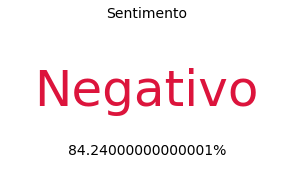

Positivo:  97.31


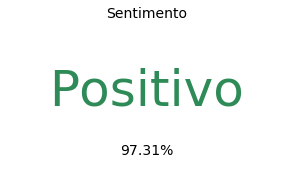

Positivo:  87.9


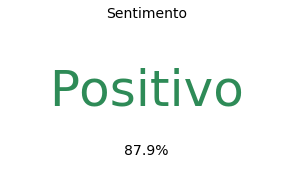

Positivo:  92.97


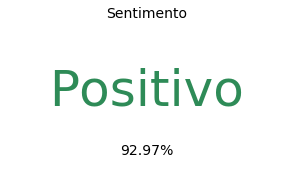

In [92]:
if __name__ == "__main__":
    main()

# Conclusão
Não é difícil criar uma solução como esta porém é trabalhosa, os dados precisam ser tratados com normalização, e filtrados. Existem muitas informações irrelevantes, como emojis, gírias, erros de português etc. E após vários testes, a melhor taxa de acurácia do modelo de redes neurais MLP, foi de 85%, o que é uma taxa aceitável. Ótimo aprendizado, fiquei satisfeito.